Goals

You are a data scientist at a large construction company. In order to submit more competitive bids for contracts, the head of analytics and data science would like you to work on forecasting core construction material costs. You have access to the pricing information (per unit, in dollars) for the company’s past purchases of plywood, sheetrock, steel beams, rebar, and glass contracts over the past ten years.

Currently, the company is able to purchase futures contracts in a material for up to six months in advance. Thus, your manager is most interested in forecasting the price of each commodity up to six months into the future. In particular, your manager feels it would be really useful to understand when a commodity price is about to increase
temporarily, in order to either buy the commodity early or wait until after the temporary increase.

# Load libraries

In [1]:
#Import modules
import pandas as pd
import numpy as np
import itertools

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = [20,8]

# Prepare the data

In [2]:
df = pd.read_excel('construction_material_prices_2008_2018.xlsx')
print(df.head())
print(df.tail())


  Unnamed: 0  price_steel  price_rebar  price_glass  price_concrete  \
0 2007-01-01          NaN          NaN          NaN             NaN   
1 2007-01-03          NaN          NaN          NaN             NaN   
2 2007-01-04          NaN          NaN          NaN             NaN   
3 2007-01-05          NaN          NaN          NaN             NaN   
4 2007-01-08          NaN          NaN          NaN             NaN   

   price_plywood  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
     Unnamed: 0  price_steel  price_rebar  price_glass  price_concrete  \
2940 2018-06-13          NaN          NaN          NaN             NaN   
2941 2018-06-14          NaN          NaN          NaN             NaN   
2942 2018-06-15          NaN          NaN          NaN             NaN   
2943 2018-06-18          NaN          NaN          NaN             NaN   
2944 2018-06-19          NaN          NaN          NaN             NaN   

      price_pl

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945 entries, 0 to 2944
Data columns (total 6 columns):
Unnamed: 0        2945 non-null datetime64[ns]
price_steel       2309 non-null float64
price_rebar       1649 non-null float64
price_glass       1472 non-null float64
price_concrete    1447 non-null float64
price_plywood     2673 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 138.1 KB


Plywood and Steel has fewer missing values. Rebar, glass, and concrete has more missing values

In [4]:
# rename date
df.rename(columns = {'Unnamed: 0':'Date'},inplace=True)

# set date as index
df.set_index('Date',inplace=True)

/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


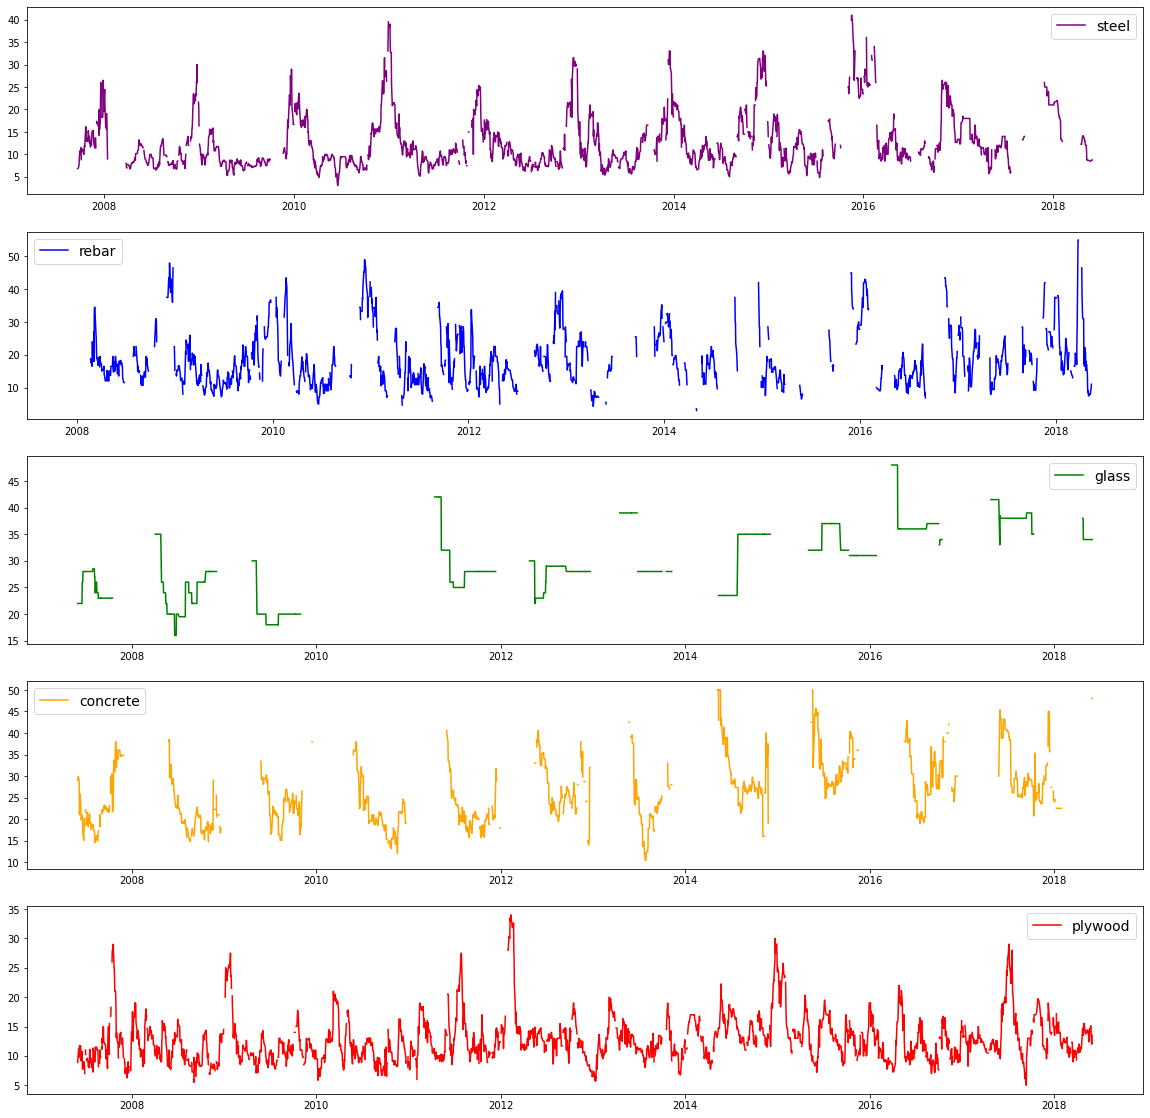

In [5]:
# plot the data

fig, ax = plt.subplots(5,1, figsize = (20,20))
ax[0].plot(df.index, df.price_steel, 
        color = 'purple', label = 'steel')
ax[1].plot(df.index, df.price_rebar, 
        color = 'blue', label = 'rebar')
ax[2].plot(df.index, df.price_glass, 
        color = 'green', label = 'glass')
ax[3].plot(df.index, df.price_concrete, 
        color = 'orange', label = 'concrete')
ax[4].plot(df.index, df.price_plywood, 
        color = 'red', label = 'plywood')
for a in ax:
    handles, labels = a.get_legend_handles_labels()
    a.legend(handles, labels, fontsize = 14)

There is temporal pattern in the price trend. I will use linear interpolation, which makes the mean between values before the missing data and the value after. (Linear interpolation involves estimating a new value by connecting two adjacent known values with a straight line. If the two known values are (x1, y1) and (x2, y2), then the y value for some point x is: Linear interpolation is a straight line fit between two data points.)

In [6]:
# linear interpolation
for col in df.columns:
    df[col] = df[col].interpolate()
    

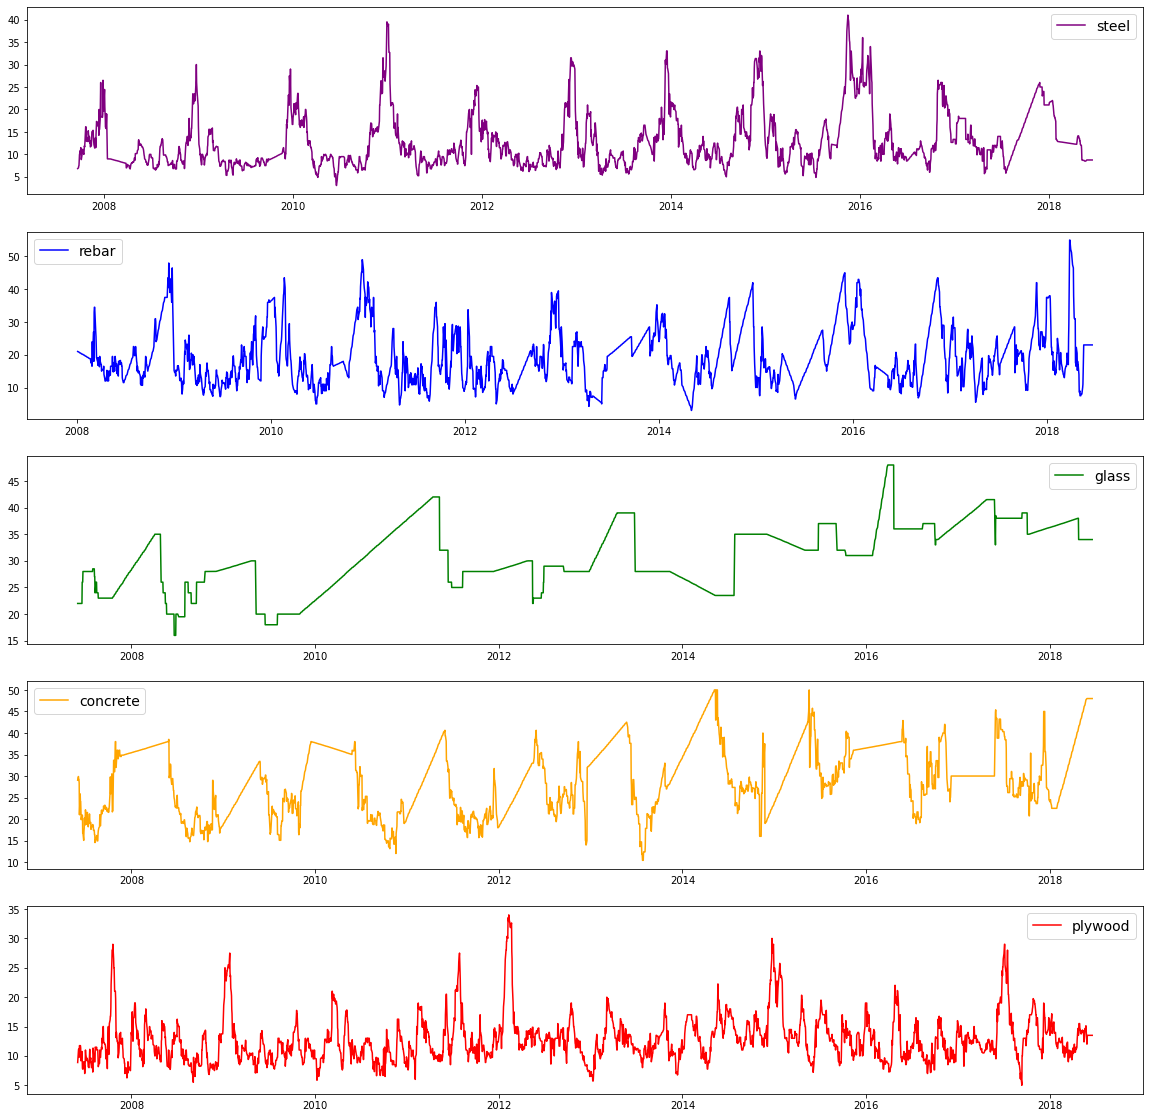

In [7]:
# plot inpolated data

fig, ax = plt.subplots(5,1, figsize = (20,20))
ax[0].plot(df.index, df.price_steel, 
        color = 'purple', label = 'steel')
ax[1].plot(df.index, df.price_rebar, 
        color = 'blue', label = 'rebar')
ax[2].plot(df.index, df.price_glass, 
        color = 'green', label = 'glass')
ax[3].plot(df.index, df.price_concrete, 
        color = 'orange', label = 'concrete')
ax[4].plot(df.index, df.price_plywood, 
        color = 'red', label = 'plywood')
for a in ax:
    handles, labels = a.get_legend_handles_labels()
    a.legend(handles, labels, fontsize = 14)

In [8]:
# break up the dataset into individual materials
plywood = df['price_plywood'].dropna()
concrete = df['price_concrete'].dropna()
glass = df['price_glass'].dropna()
rebar = df['price_rebar'].dropna()
steel = df['price_steel'].dropna()


In [9]:
# resample data to calculate monthly mean material values
plywoodmonth = plywood.resample('MS').mean()
steelmonth = steel.resample('MS').mean()
rebarmonth = rebar.resample('MS').mean()
concretemonth = concrete.resample('MS').mean()
glassmonth = glass.resample('MS').mean()

/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:3

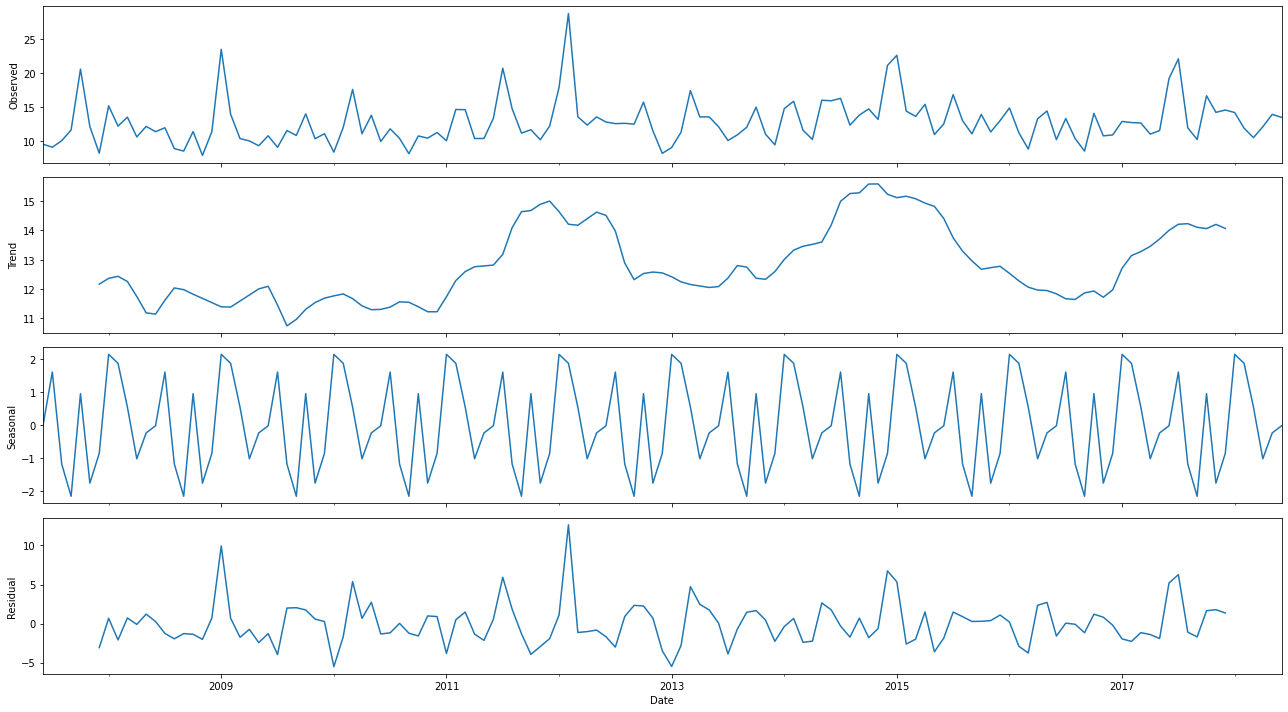

In [10]:
# monthly plywood trends
rcParams['figure.figsize'] = 18,10

decomposition = sm.tsa.seasonal_decompose(plywoodmonth, model='additive')
fig = decomposition.plot()

plt.show()

There appears to be a somewhat cyclical trend in plywood price every few years from 2012 on. There is a distinct seasonal trend in plywood prices, with the highest values at the beginning of the year and secondary peaks in the middle of the year.

/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:3

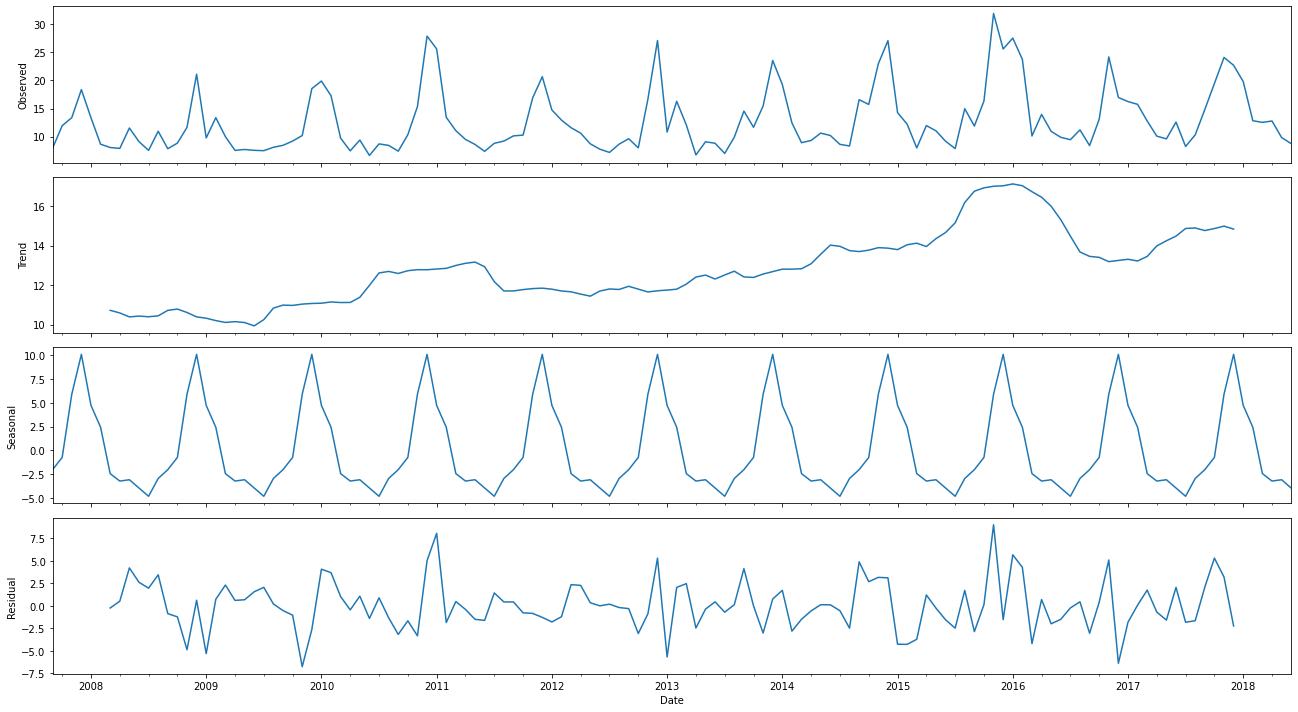

In [11]:
#Monthly steel trends
decomposition = sm.tsa.seasonal_decompose(steelmonth, model='additive')
fig = decomposition.plot()
plt.show()

There is a distinct seasonal trend for steel, with highest prices at the end of the year and lowest prices during the summer. There is a general upward trend from 2008 to 2018.

/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:3

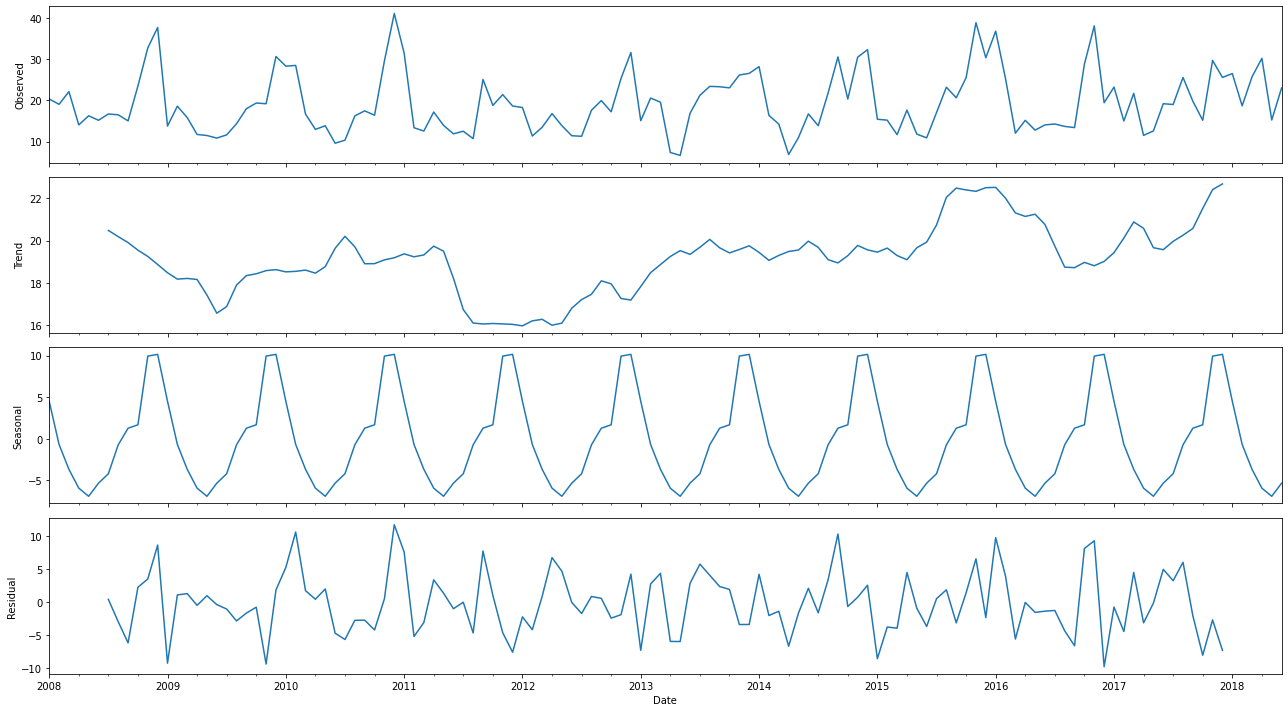

In [12]:
#Monthly rebar trends
decomposition = sm.tsa.seasonal_decompose(rebarmonth, model='additive')
fig = decomposition.plot()
plt.show()

Rebar also has a seasonal trend, with highest prices at the end of the year and lowest prices in first quarter of each year.

/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:3

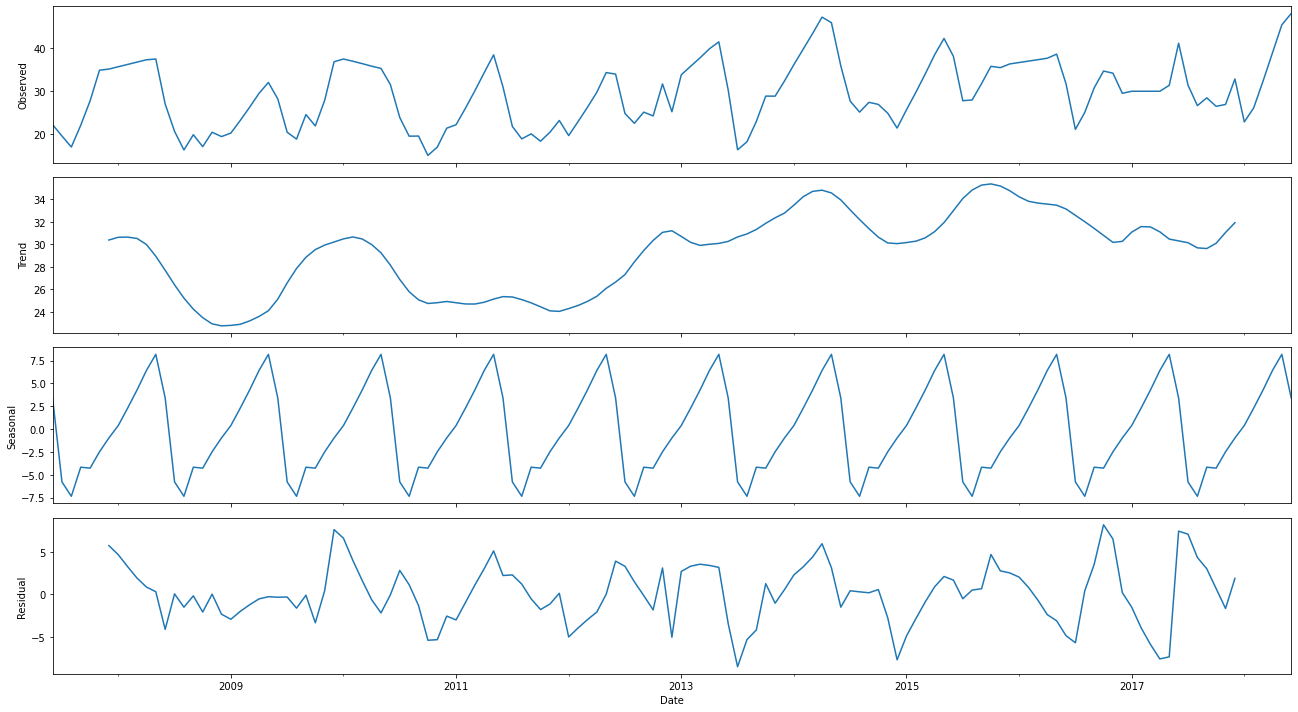

In [13]:
#Monthly concrete trends
decomposition = sm.tsa.seasonal_decompose(concretemonth, model='additive')
fig = decomposition.plot()
plt.show()

The concrete seasonal trend peaks in Q1 of each year and dips in Q2.

/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/yuan/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:3

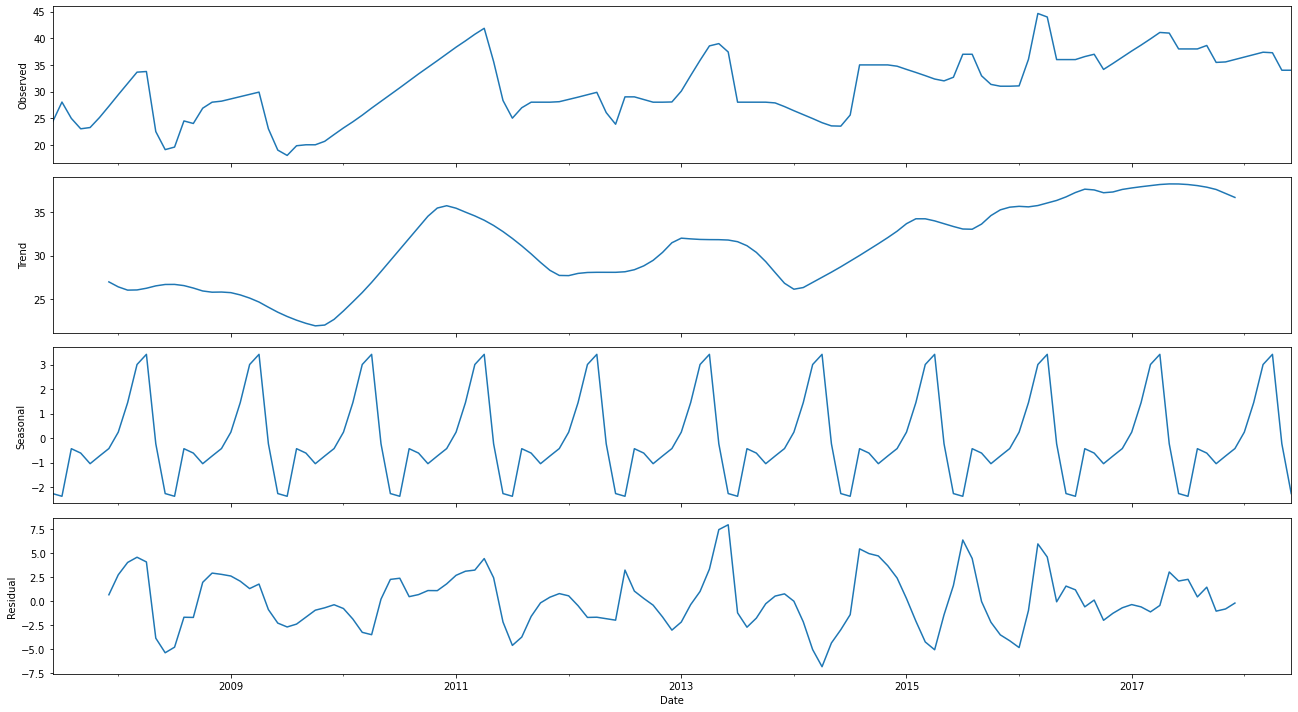

In [14]:
#Monthly glass trends
decomposition = sm.tsa.seasonal_decompose(glassmonth, model='additive')
fig = decomposition.plot()
plt.show()

The glass seasonal trends are highest in Q1 and lowest in Q2, mimicking the rebar trends.

The monthly plots show that this data is not stationary. There are seasonal trends and the residuals are not very close to zero. We will need to detrend the dataset before performing timeseries modeling so that our data becomes stationary.

# Check for Stationarity
The DFT null hpythossis is that the data is non-stationary. 

In [15]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics (smooth strend that minimize the influence of outliers )
    rolmean = timeseries.rolling(12).mean() 
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


plywood


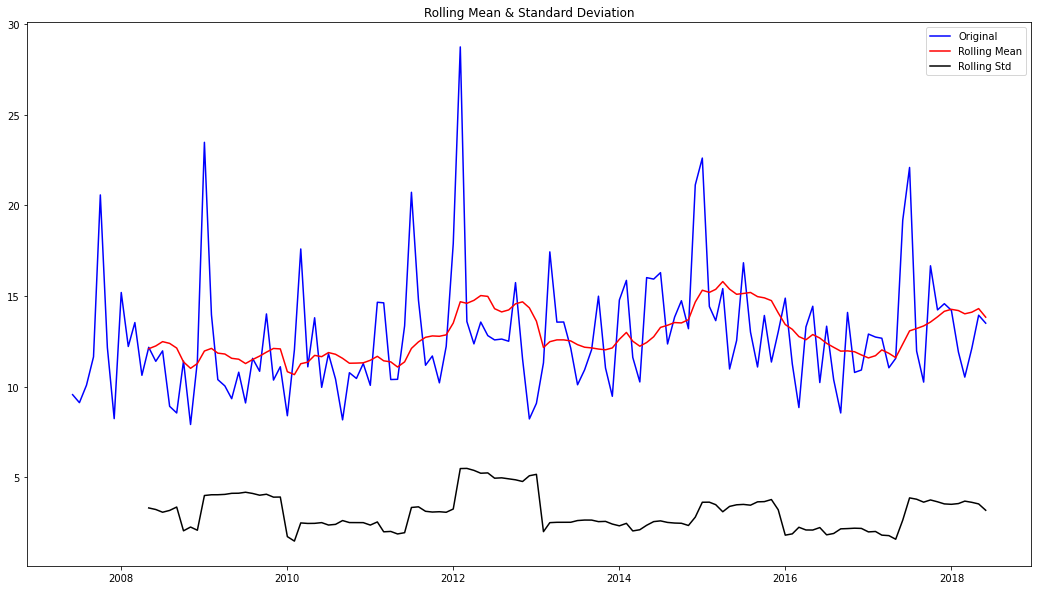

Results of Dickey-Fuller Test:
Test Statistic                -8.467591e+00
p-value                        1.507771e-13
#Lags Used                     1.000000e+00
Number of Observations Used    1.310000e+02
Critical Value (1%)           -3.481282e+00
Critical Value (5%)           -2.883868e+00
Critical Value (10%)          -2.578677e+00
dtype: float64
None
steel


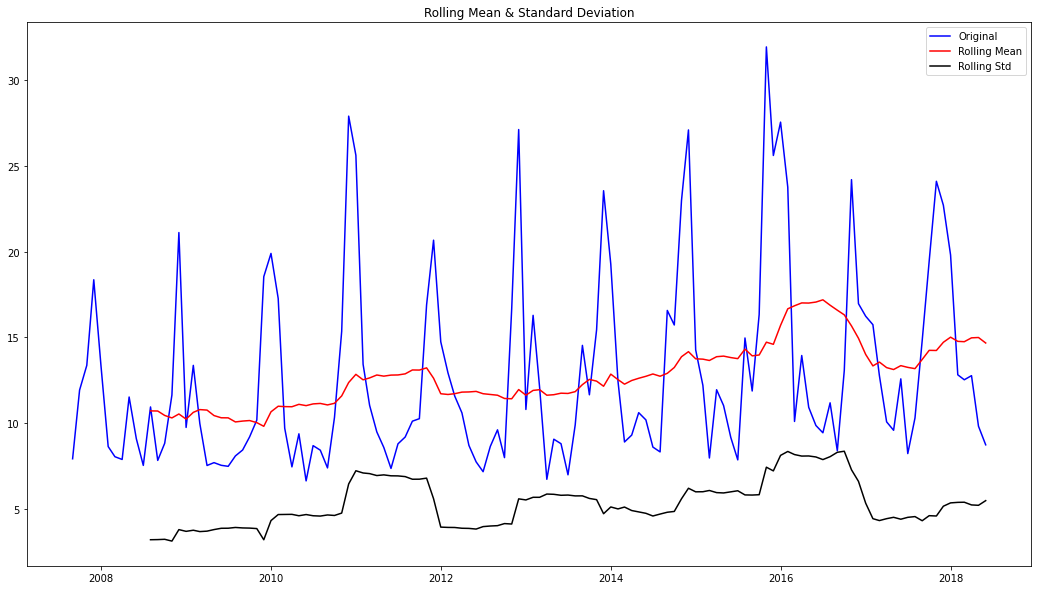

Results of Dickey-Fuller Test:
Test Statistic                  -1.454486
p-value                          0.555894
#Lags Used                      12.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64
None
rebar


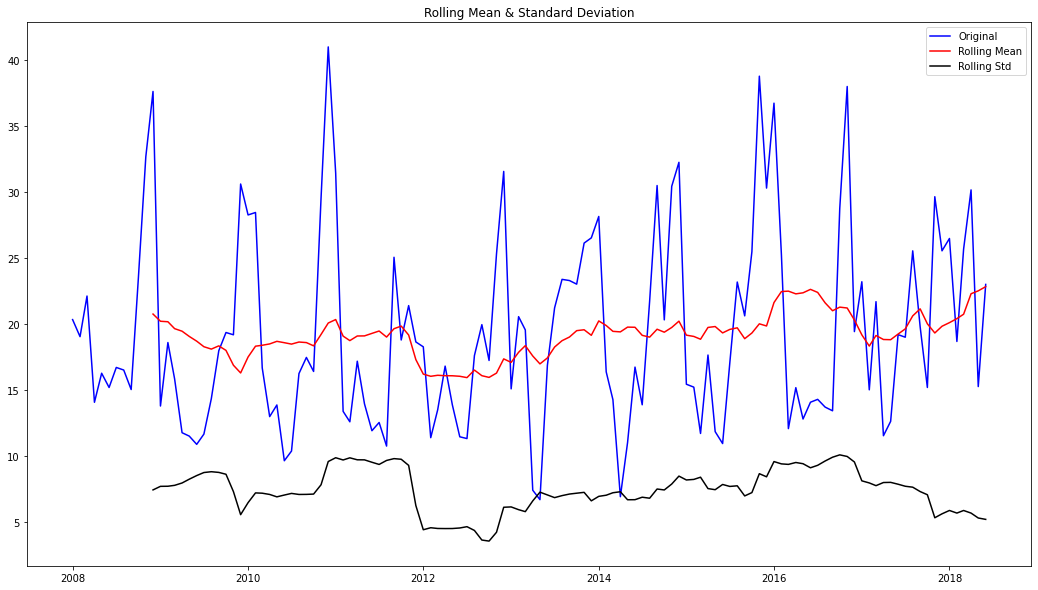

Results of Dickey-Fuller Test:
Test Statistic                -7.833650e+00
p-value                        6.197206e-12
#Lags Used                     5.000000e+00
Number of Observations Used    1.200000e+02
Critical Value (1%)           -3.486056e+00
Critical Value (5%)           -2.885943e+00
Critical Value (10%)          -2.579785e+00
dtype: float64
None
concrete


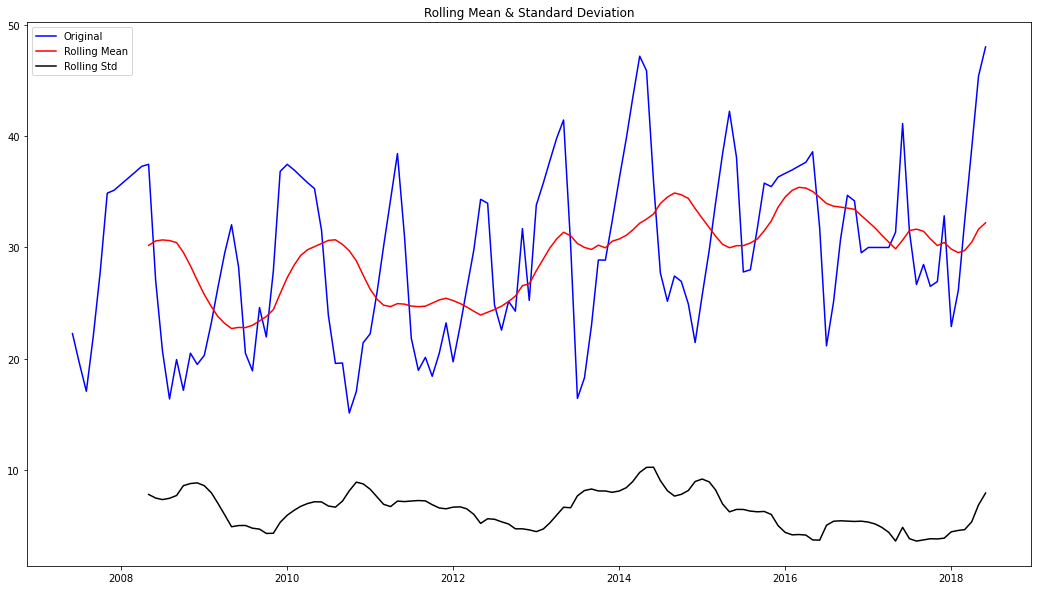

Results of Dickey-Fuller Test:
Test Statistic                  -2.312291
p-value                          0.168034
#Lags Used                      12.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64
None
glass


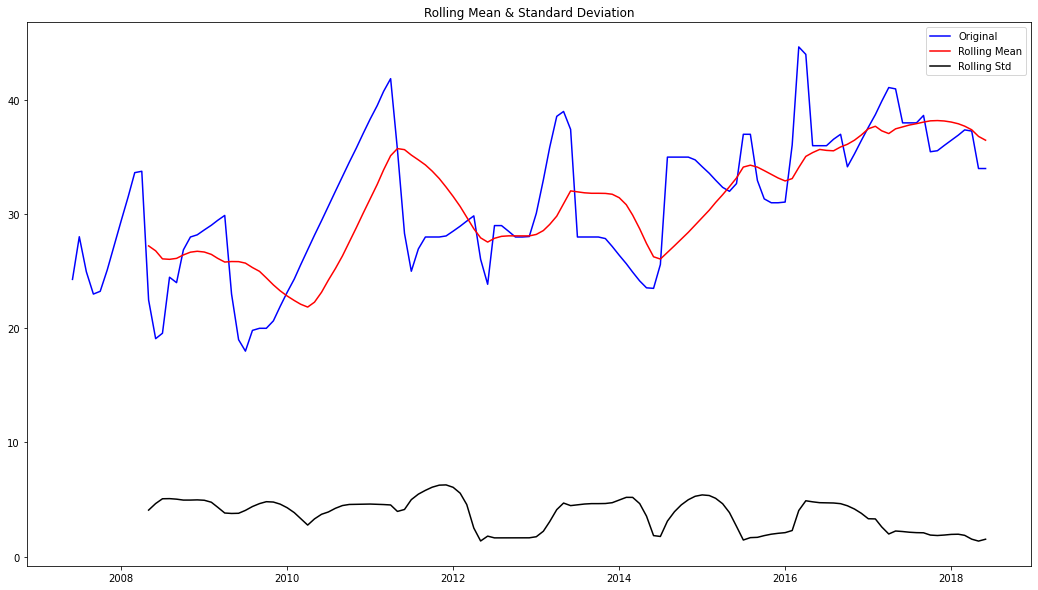

Results of Dickey-Fuller Test:
Test Statistic                  -3.072351
p-value                          0.028668
#Lags Used                       2.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
None


In [16]:
print('plywood')
print(test_stationarity(plywoodmonth))

print('steel')
print(test_stationarity(steelmonth))

print('rebar')
print(test_stationarity(rebarmonth))

print('concrete')
print(test_stationarity(concretemonth))

print('glass')
print(test_stationarity(glassmonth))


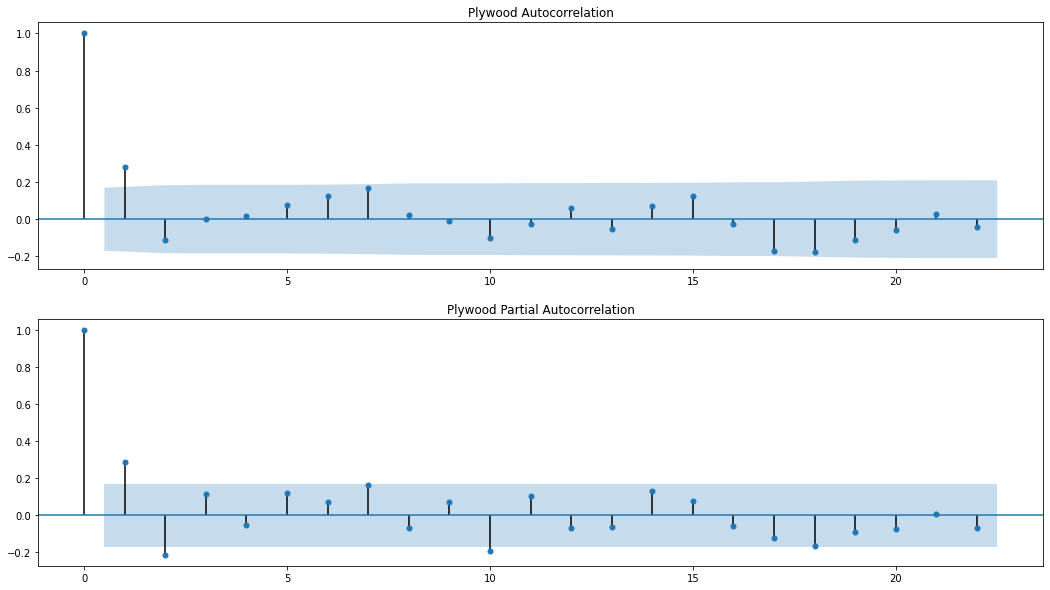

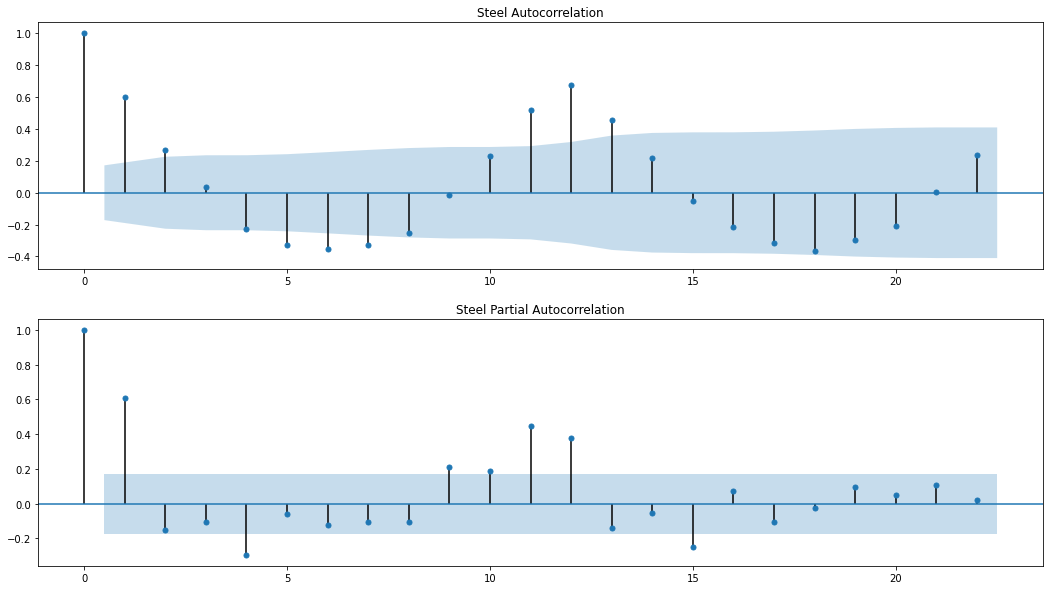

In [18]:
#Steel autocorrelation and partial autocorrelation
plt.figure()
plt.subplot(211)
plot_acf(steelmonth, ax=plt.gca())
plt.title('Steel Autocorrelation')
plt.subplot(212)
plot_pacf(steelmonth, ax=plt.gca())
plt.title('Steel Partial Autocorrelation')
plt.show()

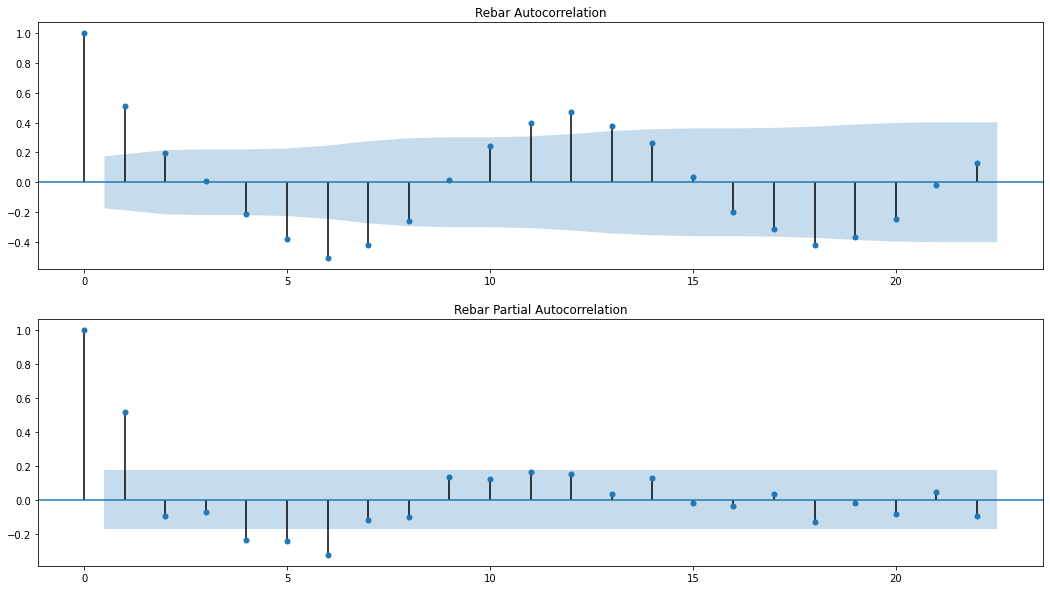

In [19]:
#Rebar autocorrelation and partial autocorrelation
plt.figure()
plt.subplot(211)
plot_acf(rebarmonth, ax=plt.gca())
plt.title('Rebar Autocorrelation')
plt.subplot(212)
plot_pacf(rebarmonth, ax=plt.gca())
plt.title('Rebar Partial Autocorrelation')
plt.show()

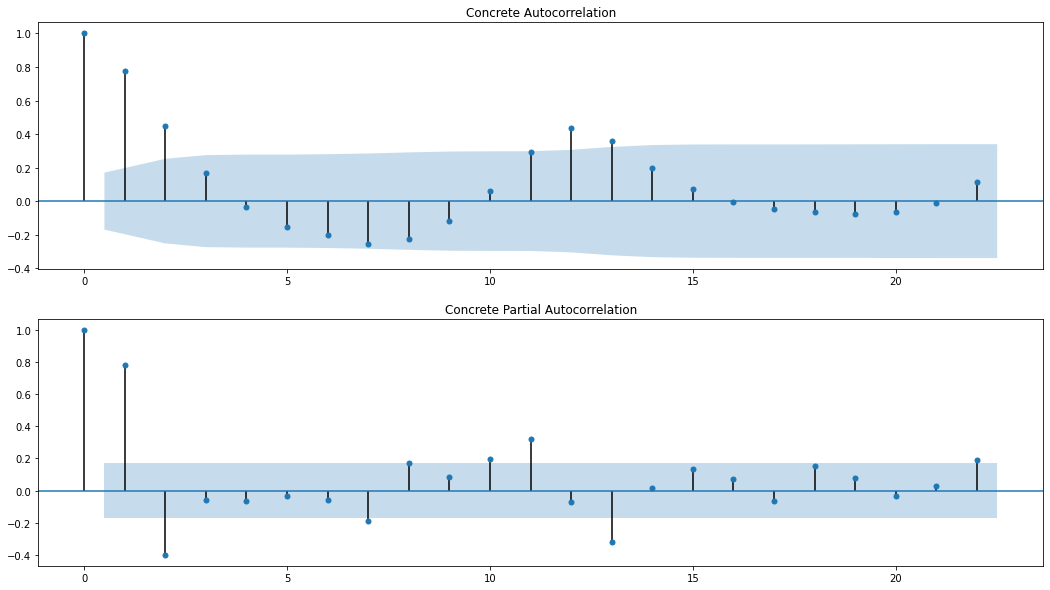

In [20]:
#Concrete autocorrelation and partial autocorrelation
plt.figure()
plt.subplot(211)
plot_acf(concretemonth, ax=plt.gca())
plt.title('Concrete Autocorrelation')
plt.subplot(212)
plot_pacf(concretemonth, ax=plt.gca())
plt.title('Concrete Partial Autocorrelation')
plt.show()

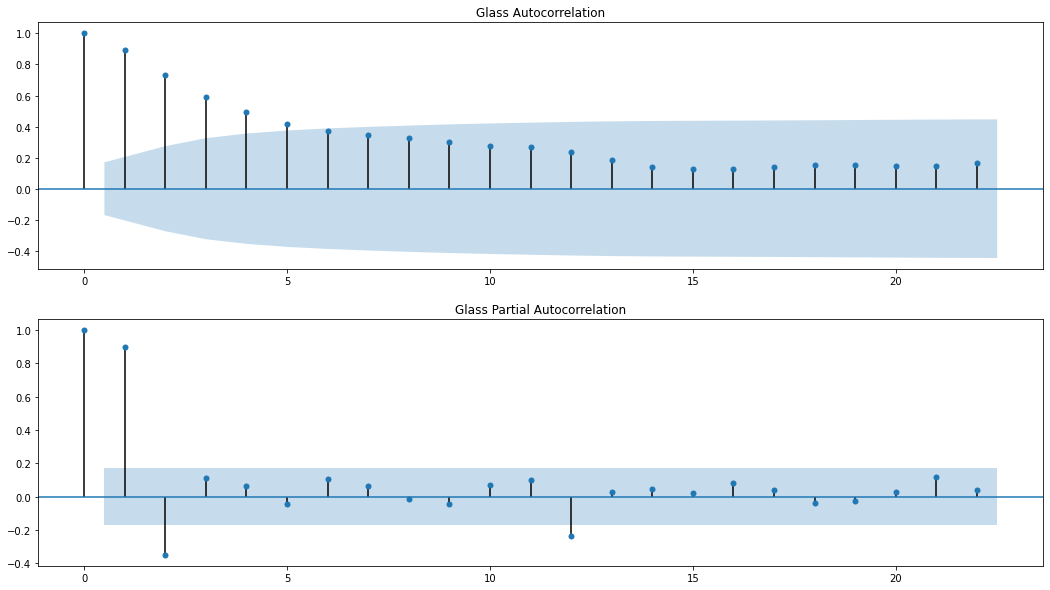

In [21]:
#Glass autocorrelation and partial autocorrelation
plt.figure()
plt.subplot(211)
plot_acf(glassmonth, ax=plt.gca())
plt.title('Glass Autocorrelation')
plt.subplot(212)
plot_pacf(glassmonth, ax=plt.gca())
plt.title('Glass Partial Autocorrelation')
plt.show()

The autocorrelation and partial autocorrelation plots suggest that the materials follow more of an autoregressive model compared to a moving average model. Armed with that knowledge, let's try out ARIMA methodology next.

# ARIMA model

Let's use grid search to determine the most optimal settings for ARIMA. Note that we will use the Akaike Information Critera (AIC), which quantifies the goodness of fit and simplicity/parsimony.

# 1. Plywood

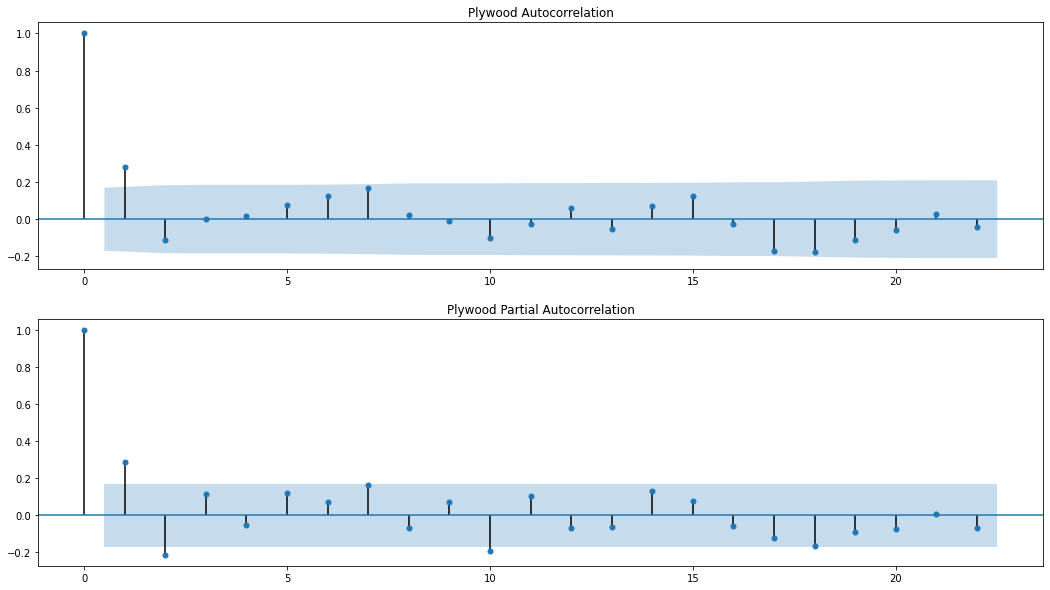

In [31]:
#Plywood autocorrelation and partial autocorrelation
plt.figure()
plt.subplot(211)
plot_acf(plywoodmonth, ax=plt.gca())
plt.title('Plywood Autocorrelation')
plt.subplot(212)
plot_pacf(plywoodmonth, ax=plt.gca())
plt.title('Plywood Partial Autocorrelation')
plt.show()

In [22]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [23]:
#Find optimal ARIMA paramaters for plywood
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(plywoodmonth,
                                           order=param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)

            
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1058.409179362787
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:865.7754783695726
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:704.9841149846776
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:580.0544255644979
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:709.7822291218428
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:649.0498239498475
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:610.8769422897491
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:587.6854875269738
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:910.8745736532969
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:766.9634934527238
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:678.6287664603528
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:557.944389730146
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:685.1796166300651
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:625.0088094088417
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:593.1594278583644
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:559.7406806825571
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:734.3764609692439
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:665.2221648503227
ARIMA(0, 1,

This configuration has lowest AIC for plywood: ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:557.944389730146

Plywood Summary Tables
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1433      0.215     -0.667      0.505      -0.564       0.278
ma.L1          0.5788      0.198      2.925      0.003       0.191       0.967
ma.S.L12      -1.0001    277.053     -0.004      0.997    -544.015     542.014
sigma2         8.3733   2320.530      0.004      0.997   -4539.782    4556.528


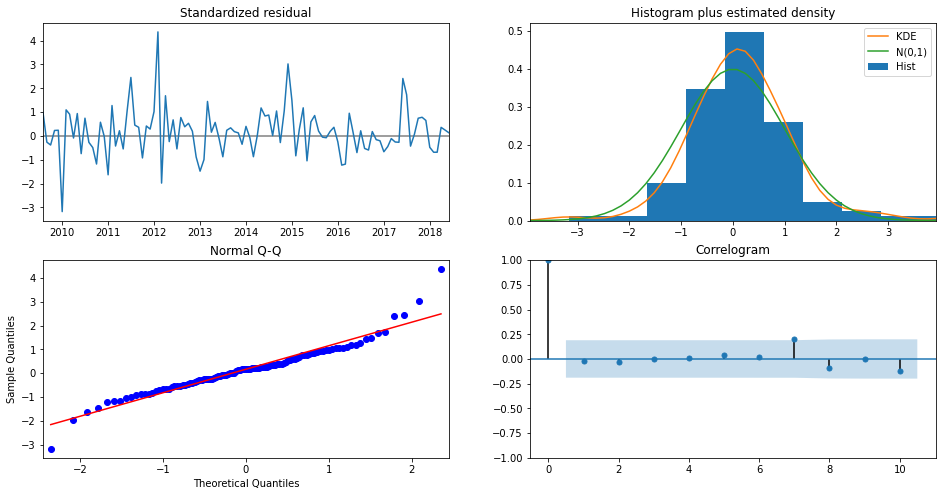

In [39]:
#Fit plywood
mod = sm.tsa.statespace.SARIMAX(plywoodmonth,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print('Plywood Summary Tables')
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

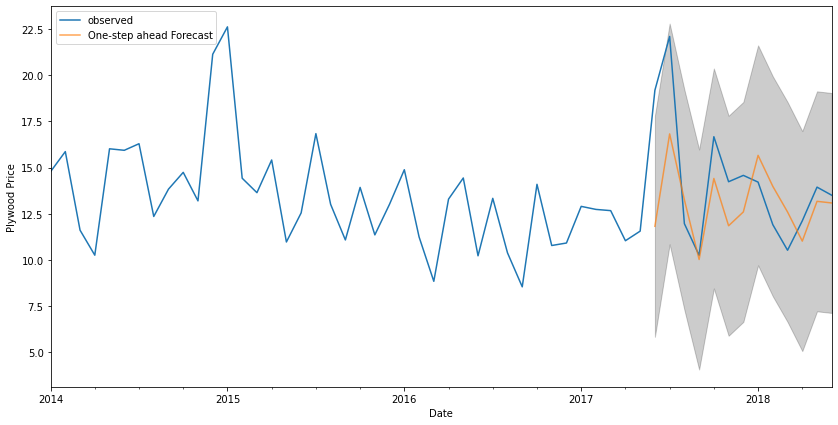

The Mean Square Error of our forecasts is 8.54
The Root Mean Squared Error of our forecasts is 2.92


In [40]:
#Validate Plywood Forecast
pred = results.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = plywoodmonth['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Plywood Price')
plt.legend()
plt.show()

#Calculate performance metrics
y_forecasted = pred.predicted_mean
y_truth = plywoodmonth['2017-01-01':]
mse = ((y_forecasted - y_truth)**2).mean()
print('The Mean Square Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


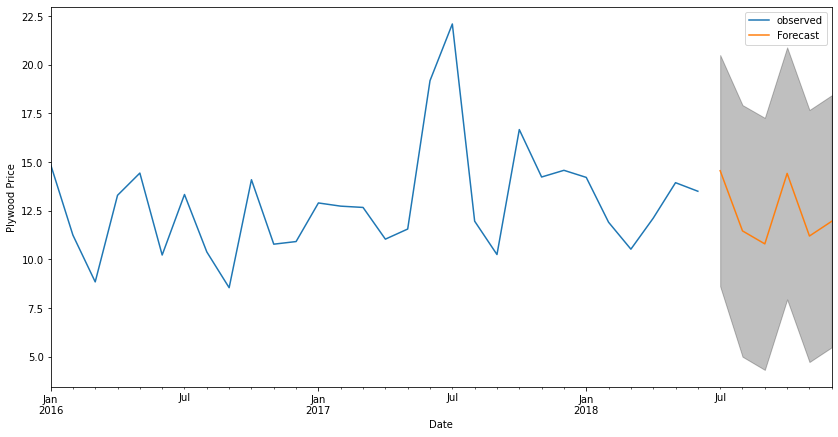

In [41]:
#Producing and visualizing forecasts
pred_uc = results.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = plywoodmonth['2016':].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Plywood Price')
plt.legend()
plt.show()

Over the next six months, Plywood is predicted to be highest in July and October, so plan to purchase plywood in August or September.

# 2. Steel

In [24]:
#Find optimal ARIMA paramaters for steel
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(steelmonth,
                                           order=param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)

            
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1048.2986466946886
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:862.302884206097
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:664.7968340687042
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:576.6093017040854
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:671.2529115692696
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:630.9774343910934


/Users/yuan/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:592.1788320052364
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:580.361603573992
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:916.0003793242525
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:771.3391067276542
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:651.2420902794938
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:562.8223379571232
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:661.7816931623313
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:622.2073896002112
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:583.9918748077051
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:564.8221912418892
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:771.6959538026508
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:685.5818252687075
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:700.9724243391122
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:603.0644113489825
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:676.6712394953468
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:666.7921708701027
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:624.529695454567
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:605.0641190609466
ARIMA(0, 1, 

This configuration has lowest AIC for steel: ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:558.1445781320385

Steel Summary Tables
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2490      0.097      2.577      0.010       0.060       0.438
ma.L1         -1.0000    306.093     -0.003      0.997    -600.932     598.932
ma.S.L12      -0.7115      0.093     -7.625      0.000      -0.894      -0.529
sigma2        11.3783   3483.382      0.003      0.997   -6815.925    6838.682


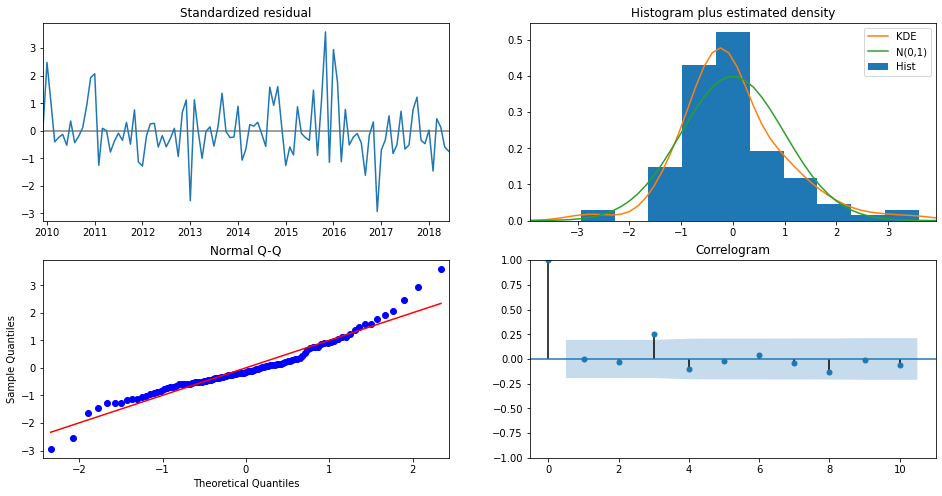

In [42]:
#Fit steel
mod = sm.tsa.statespace.SARIMAX(steelmonth,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print('Steel Summary Tables')
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

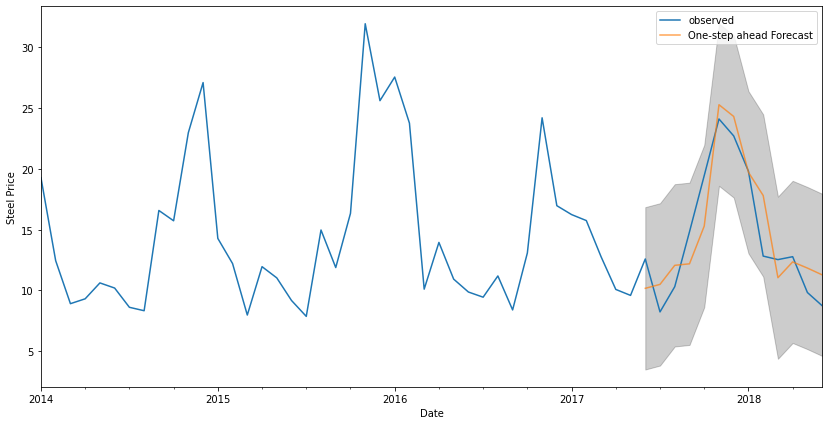

The Mean Square Error of our forecasts is 6.14
The Root Mean Squared Error of our forecasts is 2.48


In [43]:
#Validate Steel Forecast
pred = results.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = steelmonth['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steel Price')
plt.legend()
plt.show()

#Calculate performance metrics
y_forecasted = pred.predicted_mean
y_truth = steelmonth['2017-01-01':]
mse = ((y_forecasted - y_truth)**2).mean()
print('The Mean Square Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

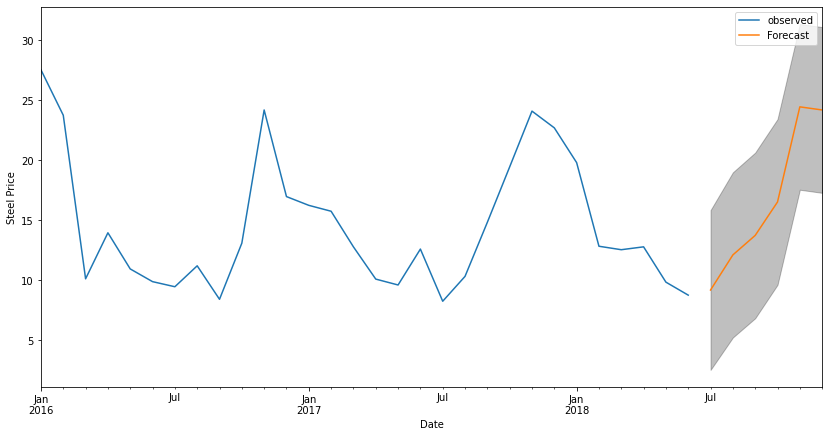

In [44]:
#Producing and visualizing forecasts
pred_uc = results.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = steelmonth['2016':].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Steel Price')
plt.legend()
plt.show()

Over the next six months,  steel should be bought as soon as possible, as prices are predicted to continue increasing for the rest of the year.

# 3. Rebar

In [25]:
#Find optimal ARIMA paramaters for rebar
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(rebarmonth,
                                           order=param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)

            
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1113.4361715247085
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:923.0415434258689
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:769.9918874613126
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:648.9663066889165
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:775.8466458089287
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:730.6984142674632
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:671.2194212218161
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:654.1226409553971
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:990.4509373843455
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:845.3677371423505
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:756.0222808118962
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:637.7619566256886
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:778.7444348168549


/Users/yuan/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:719.5090542957404
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:664.8656176793131
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:640.3112055951514
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:844.3004481857886
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:756.9233713928115
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:811.084550575506
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:683.7918225088196
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:761.574880855894
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:755.7906458647508
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:704.6162714439726
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:685.309099373911
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:835.1110882789479
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:745.4244289496885
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:764.2088953258984
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:637.9369800129426
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:745.0326396881388
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:717.7888310779867
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:671.1465304347831
ARIMA(0, 1, 1

This configuration has lowest AIC for rebar: ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:636.0372172382195

Rebar Summary Tables
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2114      0.106      1.998      0.046       0.004       0.419
ma.L1         -0.9663      0.064    -15.066      0.000      -1.092      -0.841
ma.S.L12      -0.7810      0.125     -6.253      0.000      -1.026      -0.536
sigma2        30.9707      4.549      6.809      0.000      22.056      39.886


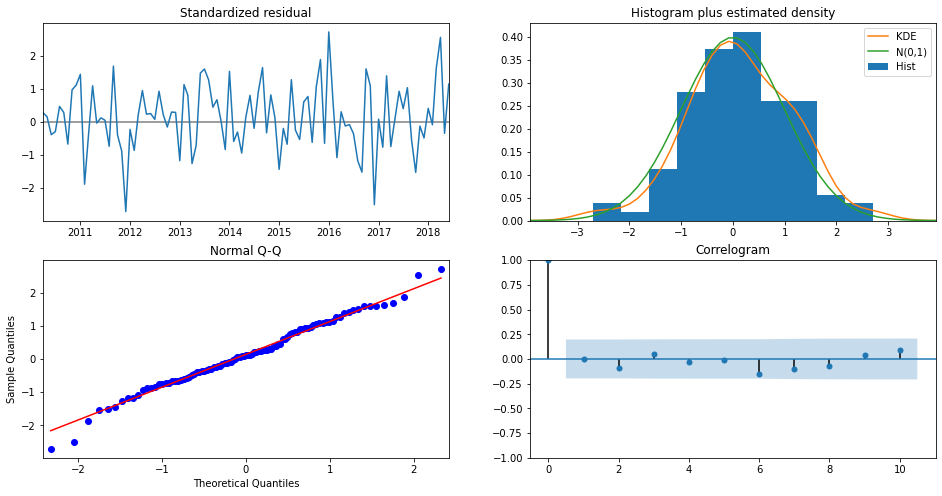

In [45]:
#Fit rebar
mod = sm.tsa.statespace.SARIMAX(rebarmonth,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print('Rebar Summary Tables')
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

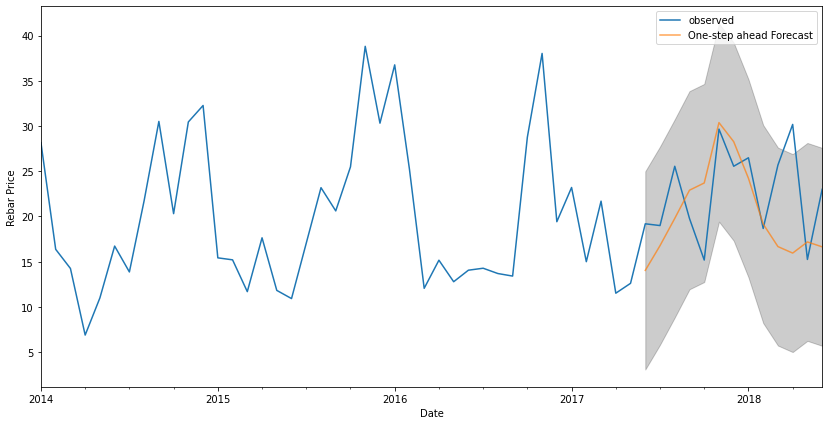

The Mean Square Error of our forecasts is 37.54
The Root Mean Squared Error of our forecasts is 6.13


In [46]:
#Validate Rebar Forecast
pred = results.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = rebarmonth['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Rebar Price')
plt.legend()
plt.show()

#Calculate performance metrics
y_forecasted = pred.predicted_mean
y_truth = rebarmonth['2017-01-01':]
mse = ((y_forecasted - y_truth)**2).mean()
print('The Mean Square Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

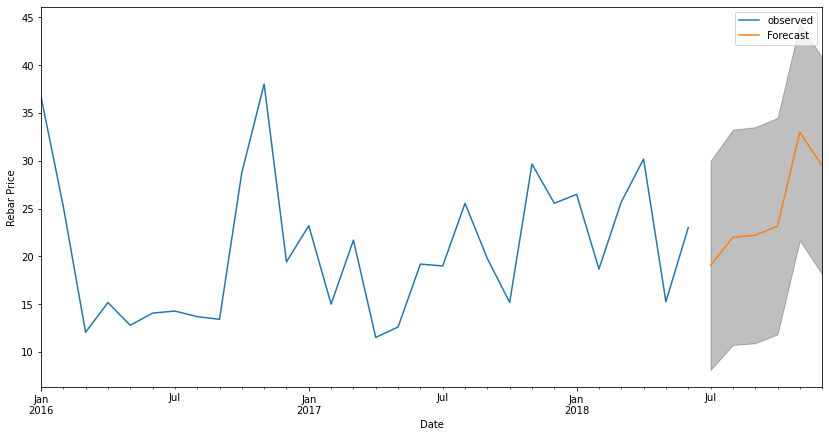

In [47]:
#Producing and visualizing forecasts
pred_uc = results.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = rebarmonth['2016':].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Rebar Price')
plt.legend()
plt.show()

Over the nexdt 6 months, Rebar should be bought as soon as possible, as prices are predicted to continue increasing for the rest of the year.

# 4. Concrete

In [26]:
#Find optimal ARIMA paramaters for concrete
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(concretemonth,
                                           order=param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)

            
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1278.2278179574741
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1051.075837169547
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:827.8965063868296
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:691.772175913398
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:835.0266150079877
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:778.2177078910479
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:709.584637381273
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:700.2239803367825
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1111.9864946849748
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:926.19112270778
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:743.5511252151475
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:623.2846526688049
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:755.345065518703
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:701.1243663679244
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:640.7525416489482
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:627.4640475200328
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:779.9974250063467
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:691.2087501823244
ARIMA(0, 1, 0

This configuration has lowest AIC for concrete: ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:587.2485777232108

Concrete Summary Tables
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7429      0.094      7.911      0.000       0.559       0.927
ma.L1          0.1539      0.119      1.298      0.194      -0.078       0.386
ma.S.L12      -0.7220      0.100     -7.249      0.000      -0.917      -0.527
sigma2        12.6815      1.444      8.783      0.000       9.852      15.511


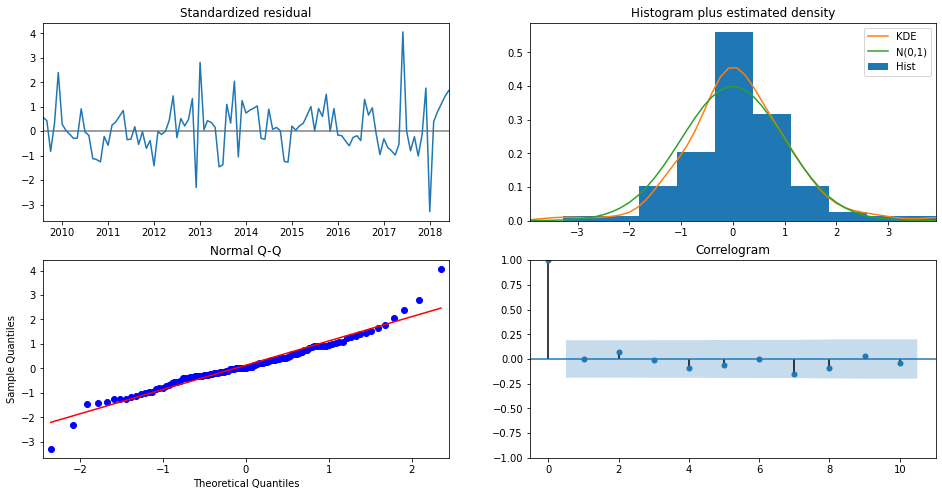

In [48]:
#Fit concrete
mod = sm.tsa.statespace.SARIMAX(concretemonth,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print('Concrete Summary Tables')
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

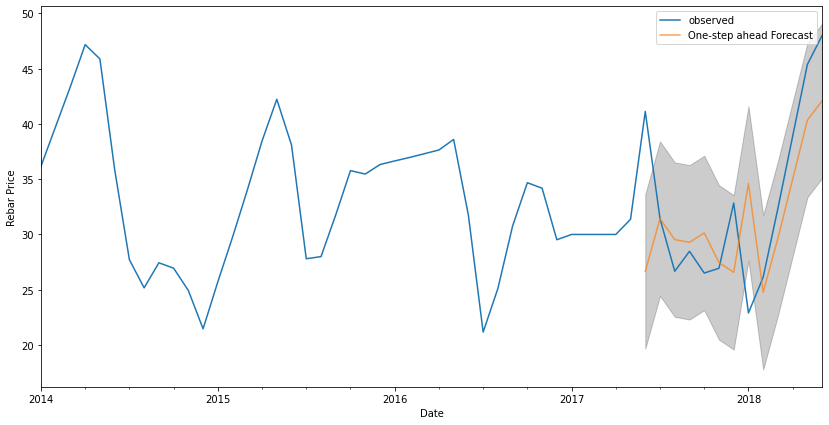

The Mean Square Error of our forecasts is 37.9
The Root Mean Squared Error of our forecasts is 6.16


In [49]:
#Validate Concrete Forecast
pred = results.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = concretemonth['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Rebar Price')
plt.legend()
plt.show()

#Calculate performance metrics
y_forecasted = pred.predicted_mean
y_truth = concretemonth['2017-01-01':]
mse = ((y_forecasted - y_truth)**2).mean()
print('The Mean Square Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

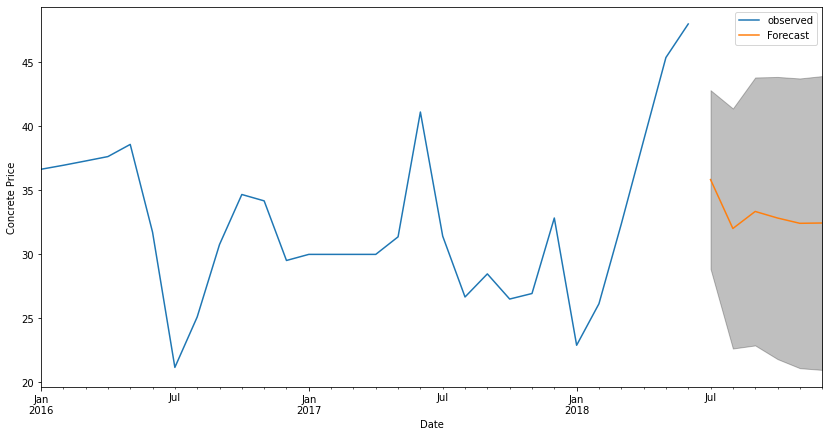

In [50]:
#Producing and visualizing forecasts
pred_uc = results.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = concretemonth['2016':].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Concrete Price')
plt.legend()
plt.show()

Concrete is predicted to be at a minimum in August 2018 but no major spikes are predicted for the rest of 2018. 

In [27]:
#Find optimal ARIMA paramaters for glass
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(glassmonth,
                                           order=param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)

            
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1287.323231834002
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1078.1481606038178
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:818.1167071809907
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:701.9811812356224
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:826.4156514971411


/Users/yuan/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:740.9094313016069
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:707.9473801466426
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:698.2076468456069
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1112.3552150988703
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:919.9385914762661
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:695.3814461285351
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:596.1356862326169
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:709.8670219416271
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:633.6253300524006
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:607.4438277769113
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:590.9205413244517
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:629.8759999631682
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:560.9532982997825
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:643.3989319868884
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:515.0349909370839
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:563.975593744906
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:554.1195674007628
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:548.5887638636663
ARIMA(0, 1

This configuration has lowest AIC for glass:ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:495.29504760019347

Glass Summary Tables
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8855      0.053     16.766      0.000       0.782       0.989
ma.L1          0.3764      0.104      3.603      0.000       0.172       0.581
ma.S.L12      -0.9144      0.204     -4.493      0.000      -1.313      -0.516
sigma2         5.2491      0.923      5.688      0.000       3.440       7.058


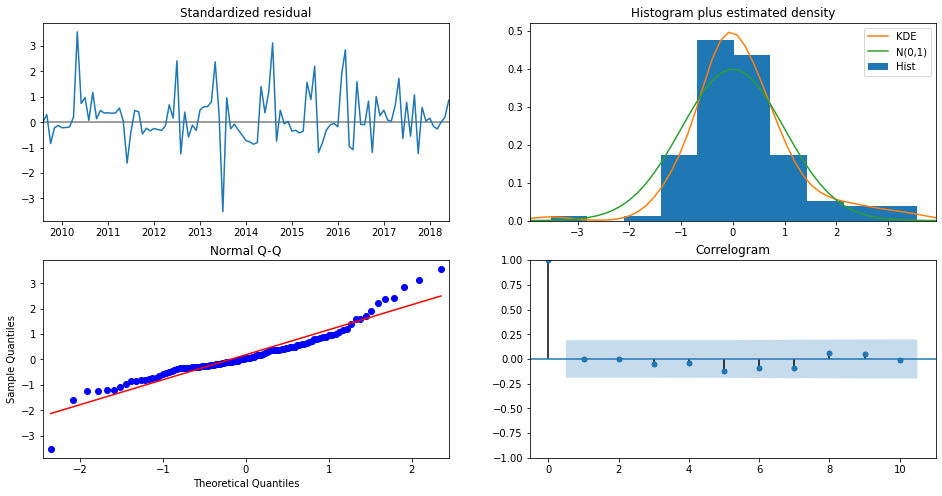

In [51]:
#Fit glass
mod = sm.tsa.statespace.SARIMAX(glassmonth,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print('Glass Summary Tables')
print(results.summary().tables[1])

results.plot_diagnostics(figsize=(16, 8))
plt.show()

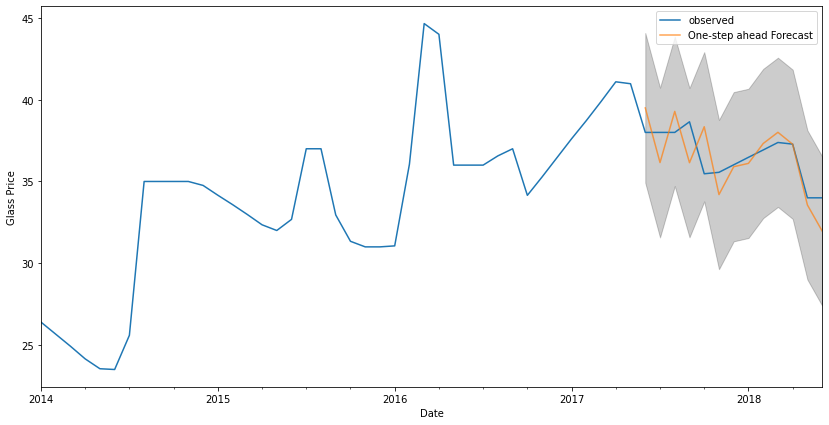

The Mean Square Error of our forecasts is 2.21
The Root Mean Squared Error of our forecasts is 1.49


In [52]:
#Validate Forecast
pred = results.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = glassmonth['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Glass Price')
plt.legend()
plt.show()

#Calculate performance metrics
y_forecasted = pred.predicted_mean
y_truth = glassmonth['2017-01-01':]
mse = ((y_forecasted - y_truth)**2).mean()
print('The Mean Square Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

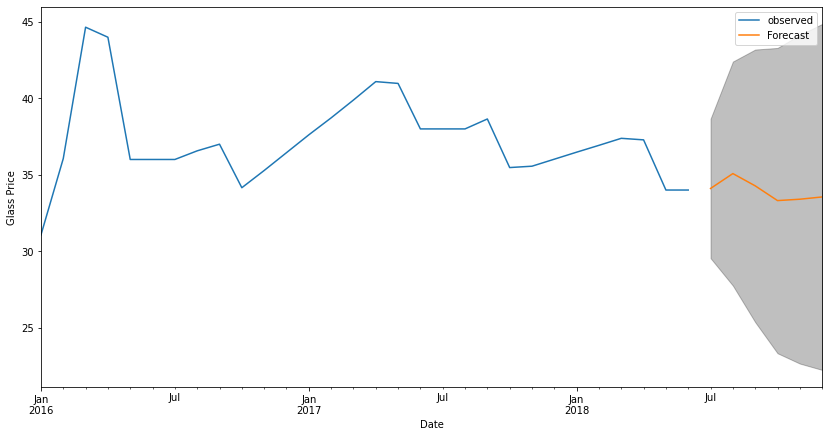

In [53]:
#Producing and visualizing forecasts
pred_uc = results.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = glassmonth['2016':].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Glass Price')
plt.legend()
plt.show()

Over the next six months, glass prices are predicted to continue decreasing, so it would be best to hold off until the end of 2018 to make a purchase.